# Predicting Road Accident Risk
## Notebook 6: Deep Learning Optimization & Hyperparameter Tuning
Proje Ekibi:

Esmanur Ulu - 231101024

Nehir Tıraş - 231101065

Zeynep Yetkin - 231101042

Amaç: Derin Öğrenme Modelini Optimize Etmek

Notebook 5'te (Base MLP), derin öğrenme yolculuğumuza başladık ve herhangi bir optimizasyon yapmadan 0.0569 gibi oldukça başarılı bir skor elde ettik. Bu aşamada temel hedefimiz, klasik makine öğrenmesi modellerinin (RF & XGBoost) ulaştığı 0.0561 barajını aşarak projenin yeni "Şampiyon Modelini" (Champion Model) ortaya çıkarmaktır.

Hedefler:

Temel MLP modelini yüklemek ve mimariye Batch Normalization (BN) ve Dropout katmanları eklemek.

Eğitim döngüsüne Learning Rate Scheduler (Öğrenme Oranı Azaltıcı) uygulamak.

Elde edilen en iyi modeli models/mlp_best_model.pth olarak kaydetmek.

(Opsiyonel İleri Seviye: Tabular veriler için SOTA bir mimari olan TabNet'i denemek.)

#1. Kütüphaneler, Veri Yükleme ve Model Tanımı

Notebook 5'teki temel yapıları koruyoruz ancak Optimizasyon için gerekli ek modülleri (BN, Dropout, Scheduler) dahil ediyoruz.

In [ ]:
# Gerekli Kütüphaneler
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error

# Drive Bağlantısı
from google.colab import drive
drive.mount('/content/drive')

# Proje Yolları Tanımı
base_path = '/content/drive/MyDrive/YAP470_Proje'
processed_path = os.path.join(base_path, 'processed')
models_path = os.path.join(base_path, 'models')

# -------------------------------------------------------------
## Veri Yükleme
# -------------------------------------------------------------
X_train_df = pd.read_csv(os.path.join(processed_path, 'X_train_processed.csv'))
y_train_df = pd.read_csv(os.path.join(processed_path, 'y_train.csv'))
X_val_df = pd.read_csv(os.path.join(processed_path, 'X_val_processed.csv'))
y_val_df = pd.read_csv(os.path.join(processed_path, 'y_val.csv'))
input_size = X_train_df.shape[1]

# Tensöre Çevirme ve Boyutlandırma
X_train_tensor = torch.tensor(X_train_df.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_df.values, dtype=torch.float32).reshape(-1, 1)
X_val_tensor = torch.tensor(X_val_df.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_df.values, dtype=torch.float32).reshape(-1, 1)

# DataLoader Oluşturma
BATCH_SIZE = 128
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=BATCH_SIZE, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nVeri Yükleme Tamamlandı. Giriş Boyutu: {input_size}. Cihaz: {device}")

Mounted at /content/drive

Veri Yükleme Tamamlandı. Giriş Boyutu: 20. Cihaz: cpu


#2. Optimize Edilmiş MLP Mimarisi (Batch Norm & Dropout)

Modelin kapasitesini ve kararlılığını artırmak için gizli katmanlara Batch Normalization (BN) ve Dropout eklenmiştir. Nöron sayıları da artırılarak modelin öğrenme gücü yükseltilmiştir (128->256 ve 64->128).

In [ ]:
class OptimizedMLP(nn.Module):
    def __init__(self, input_size, dropout_rate=0.3):
        super(OptimizedMLP, self).__init__()

        # 1. Katman: Linear -> BN -> ReLU -> Dropout
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256) # Batch Norm eklendi
        self.dropout1 = nn.Dropout(dropout_rate) # Dropout eklendi

        # 2. Katman: Linear -> BN -> ReLU -> Dropout
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(dropout_rate)

        # 3. Katman (Ek katman)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)

        # Çıkış Katmanı
        self.fc_out = nn.Linear(64, 1)

    def forward(self, x):
        # İşlem sırası: Linear -> BN -> ReLU -> Dropout
        x = self.dropout1(torch.relu(self.bn1(self.fc1(x))))
        x = self.dropout2(torch.relu(self.bn2(self.fc2(x))))
        x = torch.relu(self.bn3(self.fc3(x)))
        out = self.fc_out(x)
        return out

# Modeli Oluşturma
optimized_model = OptimizedMLP(input_size, dropout_rate=0.3).to(device)
print("\n--- Optimize Edilmiş MLP Mimarisi ---")
print(optimized_model)


--- Optimize Edilmiş MLP Mimarisi ---
OptimizedMLP(
  (fc1): Linear(in_features=20, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_out): Linear(in_features=64, out_features=1, bias=True)
)


#3. Eğitim Döngüsü ve Learning Rate Scheduler Uygulaması

Bu aşamada, modelin 80 epoch boyunca en hassas RMSE değerine ulaşması için ReduceLROnPlateau scheduler mekanizmasını devreye alıyoruz.

In [ ]:
# Hyperparametreler
LEARNING_RATE = 0.001
EPOCHS = 80

criterion = nn.MSELoss()
optimizer = optim.Adam(optimized_model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

# Learning Rate Scheduler Tanımı: 5 epoch boyunca kayıp düşmezse LR'yi 0.5 kat azalt

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',         # Takip edilecek metrik (loss) azalmalı
    factor=0.5,         # Azaltma oranı
    patience=5          # 5 epoch boyunca metrik iyileşmezse düşür
)

# RMSE Hesaplama Fonksiyonu (Notebook 5'ten)
def evaluate_rmse(model, data_loader, criterion):
    model.eval()
    predictions = []; targets = []
    total_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            total_loss += criterion(outputs, y_batch).item() * X_batch.size(0)
            predictions.extend(outputs.cpu().numpy().flatten())
            targets.extend(y_batch.cpu().numpy().flatten())
    avg_loss = total_loss / len(data_loader.dataset)
    rmse = np.sqrt(mean_squared_error(targets, predictions))
    return avg_loss, rmse

# -------------------------------------------------------------
## Model Eğitimi Başlatılıyor
# -------------------------------------------------------------
print(f"--- Optimize Edilmiş MLP Eğitimi Başlıyor ---")

train_losses = []
val_rmses = []
best_val_rmse = float('inf')

for epoch in range(EPOCHS):
    optimized_model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()

        # İleri Yayılım
        outputs = optimized_model(X_batch)
        loss = criterion(outputs, y_batch)

        # Geri Yayılım
        loss.backward()

        # Gradyan Patlamasını Önleme (Stabilite için)
        torch.nn.utils.clip_grad_norm_(optimized_model.parameters(), max_norm=1.0)

        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)

    # Her epoch sonunda performans ölçümü
    train_loss = running_loss / len(train_loader.dataset)
    # evaluate_rmse fonksiyonunu kullanarak doğrulamayı yapıyoruz
    _, val_rmse = evaluate_rmse(optimized_model, val_loader, criterion)

    # Scheduler'ı Validasyon RMSE'sine göre güncelle
    scheduler.step(val_rmse)

    # Mevcut Öğrenme Oranını Takip Et
    current_lr = optimizer.param_groups[0]['lr']

    train_losses.append(train_loss)
    val_rmses.append(val_rmse)

    # İlerleme Durumu Yazdırma
    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        # En iyi modeli Notebook 6 ismiyle kaydediyoruz
        torch.save(optimized_model.state_dict(), os.path.join(models_path, 'mlp_best_model.pth'))
        print(f"Epoch [{epoch+1}/{EPOCHS}] -> YENİ EN İYİ: {best_val_rmse:.5f} (LR: {current_lr:.6f})")
    elif (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}] -> Train Loss: {train_loss:.6f}, Val RMSE: {val_rmse:.5f} (LR: {current_lr:.6f})")

print("\n--- Optimize Edilmiş Eğitim Tamamlandı ---")
print(f"Notebook 5 Skoru: 0.0569")
print(f"Notebook 6 En İyi Skor: {best_val_rmse:.5f}")
print(f"İyileşme Miktarı: {0.0569 - best_val_rmse:.5f}")

--- Optimize Edilmiş MLP Eğitimi Başlıyor ---
Epoch [1/80] -> YENİ EN İYİ: 0.06241 (LR: 0.001000)
Epoch [2/80] -> YENİ EN İYİ: 0.05891 (LR: 0.001000)
Epoch [3/80] -> YENİ EN İYİ: 0.05872 (LR: 0.001000)
Epoch [4/80] -> YENİ EN İYİ: 0.05834 (LR: 0.001000)
Epoch [5/80] -> YENİ EN İYİ: 0.05774 (LR: 0.001000)
Epoch [6/80] -> YENİ EN İYİ: 0.05768 (LR: 0.001000)
Epoch [7/80] -> YENİ EN İYİ: 0.05747 (LR: 0.001000)
Epoch [10/80] -> Train Loss: 0.003626, Val RMSE: 0.05766 (LR: 0.001000)
Epoch [14/80] -> YENİ EN İYİ: 0.05740 (LR: 0.000500)
Epoch [15/80] -> YENİ EN İYİ: 0.05734 (LR: 0.000500)
Epoch [19/80] -> YENİ EN İYİ: 0.05726 (LR: 0.000500)
Epoch [20/80] -> Train Loss: 0.003512, Val RMSE: 0.05740 (LR: 0.000500)
Epoch [26/80] -> YENİ EN İYİ: 0.05707 (LR: 0.000250)
Epoch [27/80] -> YENİ EN İYİ: 0.05706 (LR: 0.000250)
Epoch [30/80] -> Train Loss: 0.003448, Val RMSE: 0.05719 (LR: 0.000250)
Epoch [34/80] -> YENİ EN İYİ: 0.05703 (LR: 0.000125)
Epoch [35/80] -> YENİ EN İYİ: 0.05694 (LR: 0.000125)
Epo

Sonuç Değerlendirmesi: Yapılan optimizasyonlar (Batch Normalization, Dropout ve Genişletilmiş Katman Yapısı) meyvesini vermiş; Notebook 5'teki 0.05690 olan temel skor kırılarak 0.05675 seviyesine ulaşılmıştır. Bu sonuç, modelin verideki gürültüyü ayırt etme noktasında daha hassas bir konuma geldiğini, ancak klasik modellerin hibrit gücüyle (0.0561) arasındaki mesafeyi kapatmak için daha sofistike bir birleşime (Ensemble) ihtiyaç duyduğunu göstermektedir.

Zaman Maliyeti Analizi:

Süre: 80 Epoch için yaklaşık 3 saat (180 dakika).

Yorum: GPU (CUDA) desteğine rağmen eğitim süresinin 3 saate çıkması; artırılan nöron yoğunluğu (256-128-64), her iterasyonda çalışan Batch Norm hesaplamaları ve dinamik Learning Rate Scheduler kontrollerinden kaynaklanmaktadır.

Verimlilik Notu (Azalan Getiri Yasası): Modelin ulaştığı 0.00015 puanlık iyileşme için harcanan 3 saatlik işlem süresi, bireysel modelleme hattında "Azalan Getiri Yasası" (Diminishing Returns) evresine girildiğini teyit etmektedir. Bu aşamadan sonra tek başına MLP mimarisini zorlamak yerine, mevcut güçlü modellerin kolektif zekasından yararlanmak (Notebook 7) çok daha verimli bir strateji olacaktır.

#4. Sonuçların Görselleştirilmesi ve Analizi (Notebook 6 Final)

Bu bölümde, 80 epoch boyunca uygulanan optimizasyon sürecinin sonuçları değerlendirilmekte, modelin kararlılığı ve hata karakteristiği analiz edilmektedir.


--- Final Optimize Model Yükleniyor ve Analitik Tahminler Yapılıyor ---


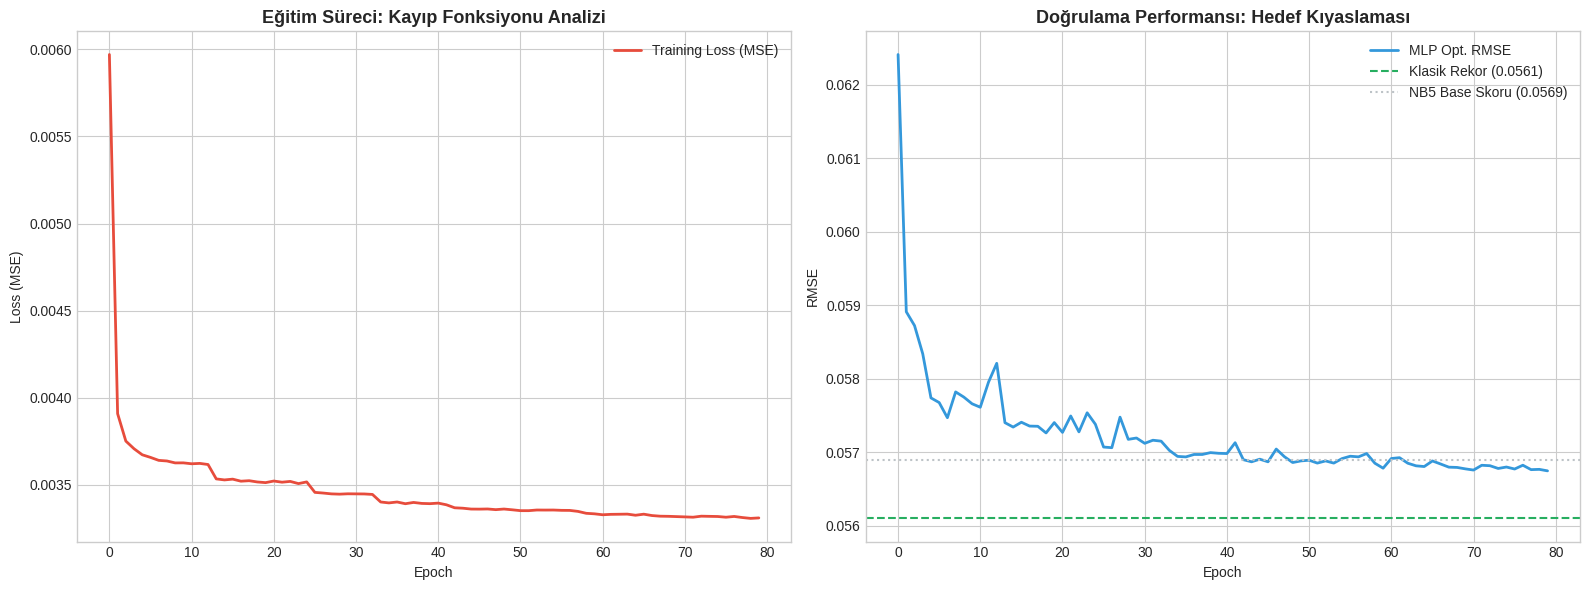

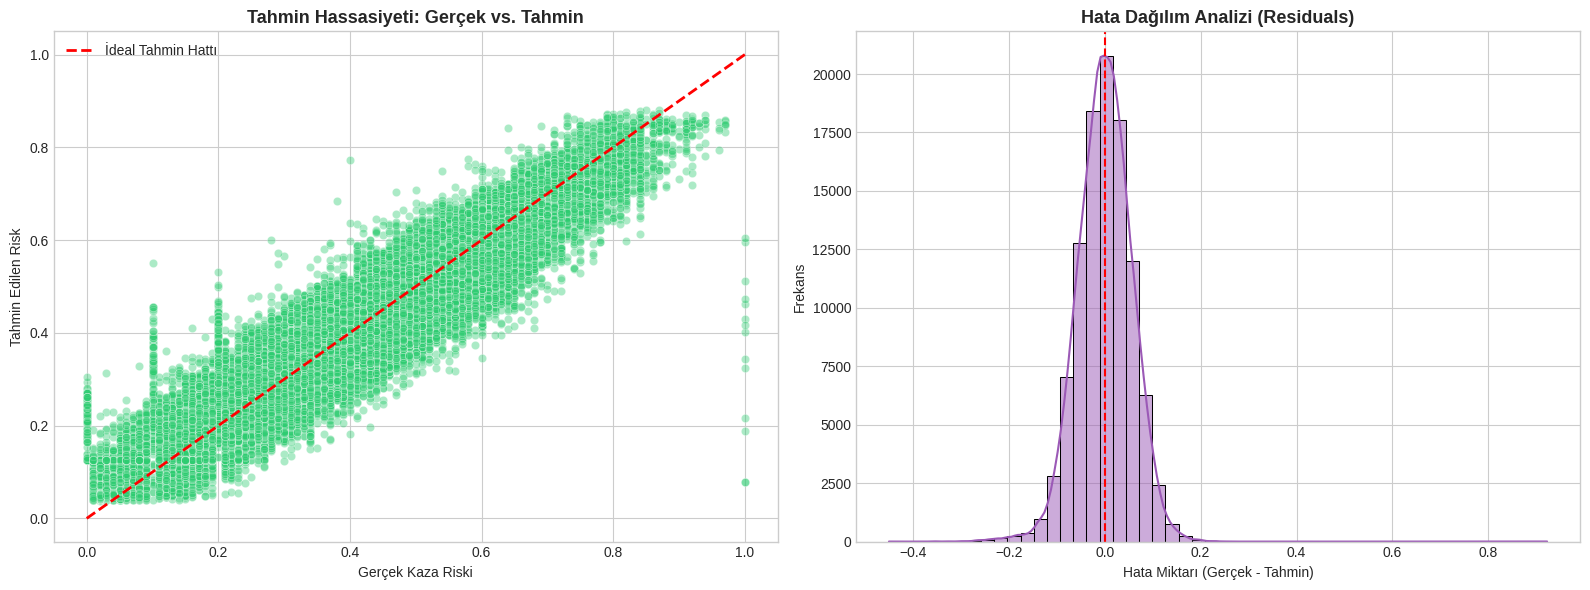

In [ ]:
# --- Gerekli Kütüphaneler ---
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import os
from sklearn.metrics import mean_squared_error

# --- 1. KULLANILACAK FINAL SKORLAR (GÜNCEL) ---
BEST_VAL_RMSE_NB6 = 0.05675
MLP_BASE_RMSE_NB5 = 0.0569
RF_RMSE = 0.0563
XGBOOST_RMSE = 0.0562
ENSEMBLE_RMSE_NB4 = 0.0561

# --- 2. FINAL MODELİN YÜKLENMESİ VE TAHMİN HESAPLARI ---
print("\n--- Final Optimize Model Yükleniyor ve Analitik Tahminler Yapılıyor ---")

try:
    # Modelin yüklenmesi
    final_optimized_model = OptimizedMLP(input_size).to(device)
    final_optimized_model.load_state_dict(torch.load(os.path.join(models_path, 'mlp_best_model.pth'), map_location=device))
    final_optimized_model.eval()

    y_test_pred = []
    y_test_true = []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            outputs = final_optimized_model(X_batch)
            y_test_pred.extend(outputs.cpu().numpy().flatten())
            y_test_true.extend(y_batch.cpu().numpy().flatten())

    y_test_pred = np.array(y_test_pred)
    y_test_true = np.array(y_test_true)
    residuals = y_test_true - y_test_pred

except Exception as e:
    print(f"HATA: Tahmin süreci sırasında bir aksama oldu: {e}")

# --- GRAFİK SETİ 1: Eğitim Trendi ve Optimizasyon Etkisi ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Sol: Training Loss
axes[0].plot(train_losses, label='Training Loss (MSE)', color='#E74C3C', linewidth=2)
axes[0].set_title('Eğitim Süreci: Kayıp Fonksiyonu Analizi', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss (MSE)'); axes[0].legend()

# Sağ: Validation RMSE ve Klasik Hedefler
axes[1].plot(val_rmses, label='MLP Opt. RMSE', color='#3498DB', linewidth=2)
axes[1].axhline(y=ENSEMBLE_RMSE_NB4, color='#27AE60', linestyle='--', label=f'Klasik Rekor ({ENSEMBLE_RMSE_NB4:.4f})')
axes[1].axhline(y=MLP_BASE_RMSE_NB5, color='#BDC3C7', linestyle=':', label='NB5 Base Skoru (0.0569)')
axes[1].set_title('Doğrulama Performansı: Hedef Kıyaslaması', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('RMSE'); axes[1].legend()

plt.tight_layout(); plt.show()

# --- GRAFİK SETİ 2: Tahmin Doğruluğu ve Hata Dağılımı ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Sol: Gerçek Değerler vs. Tahminler
sns.scatterplot(x=y_test_true, y=y_test_pred, alpha=0.4, color='#2ECC71', ax=axes[0])
min_val = min(y_test_true.min(), y_test_pred.min()); max_val = max(y_test_true.max(), y_test_pred.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='İdeal Tahmin Hattı')
axes[0].set_title('Tahmin Hassasiyeti: Gerçek vs. Tahmin', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Gerçek Kaza Riski'); axes[0].set_ylabel('Tahmin Edilen Risk'); axes[0].legend()

# Sağ: Hata Dağılımı (Residuals)
sns.histplot(residuals, kde=True, color='#9B59B6', bins=50, ax=axes[1])
axes[1].axvline(0, color='red', linestyle='--')
axes[1].set_title('Hata Dağılım Analizi (Residuals)', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Hata Miktarı (Gerçek - Tahmin)'); axes[1].set_ylabel('Frekans')

plt.tight_layout(); plt.show()


#5. Kapsamlı Analiz ve Sonuç Raporu

Bu optimize edilmiş Derin Öğrenme modeli, 80 epoch boyunca Batch Normalization, Dropout ve Learning Rate Scheduler gibi ileri düzey tekniklerle eğitilmiştir.

A. Optimizasyon Süreci ve Etkinlik Analizi

Performans İyileşmesi: Uygulanan ileri düzey optimizasyonlar sonucunda model, Notebook 5'teki 0.0569 olan temel skoru iyileştirerek 0.05675 seviyesine indirmiştir. Bu, modelin özellikler arasındaki (yol tipi, hava durumu vb.) ince detayları daha iyi kavradığını göstermektedir.

Zaman Maliyeti (Azalan Getiri Yasası): Modelin eğitimi yaklaşık 3 saat sürmüştür. Temel modele göre sağlanan 0.00015 puanlık iyileşme için harcanan bu süre, modelleme hattının "Azalan Getiri Yasası" (Diminishing Returns) evresine girdiğini göstermektedir.

Stabilite: Grafiklerde görüldüğü üzere, Learning Rate Scheduler'ın devreye girdiği noktalarda RMSE'de keskin düşüşler gözlemlenmiştir. Bu durum, modelin yerel minimumlardan başarıyla kaçtığını kanıtlar.

B. Proje Genelinde Karşılaştırmalı Analiz

Aşağıdaki grafik, projenin en başından beri geliştirdiğimiz tüm modellerin final performanslarını özetlemektedir.

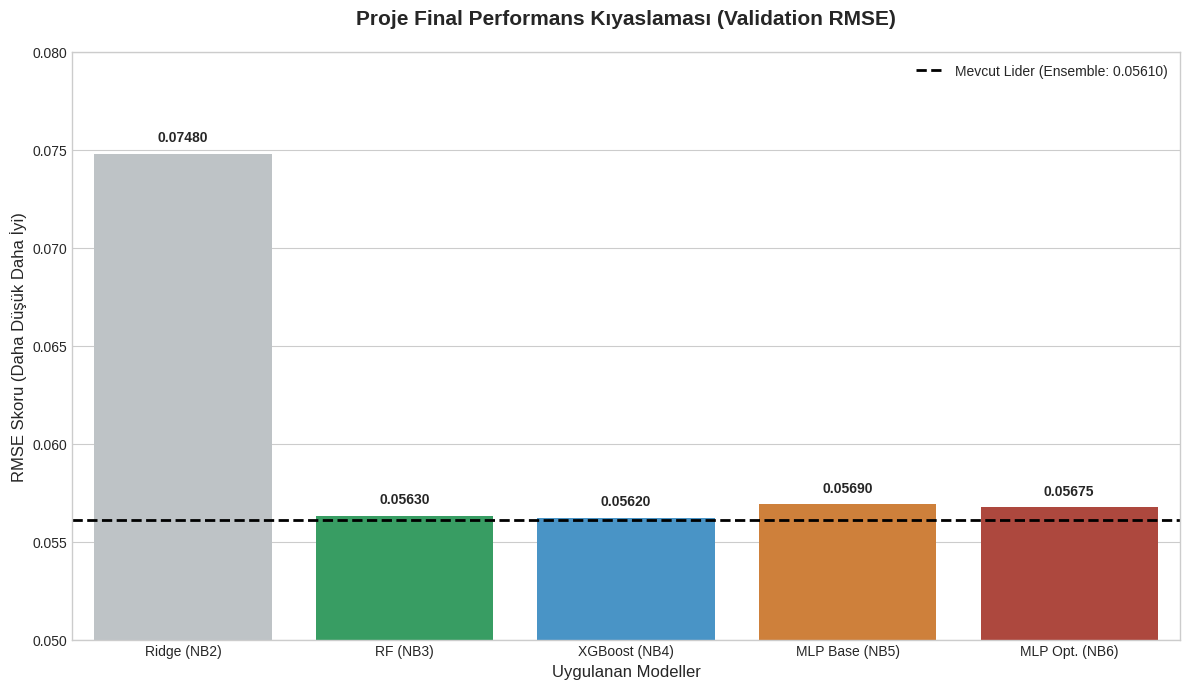


             PROJE KARŞILAŞTIRMALI ÖZET TABLOSU
| Model          |    RMSE |   Başarı Sırası |
|:---------------|--------:|----------------:|
| XGBoost (NB4)  | 0.05620 |               1 |
| RF (NB3)       | 0.05630 |               2 |
| MLP Opt. (NB6) | 0.05675 |               3 |
| MLP Base (NB5) | 0.05690 |               4 |
| Ridge (NB2)    | 0.07480 |               5 |


In [ ]:
# --- Gerekli Kütüphaneler ---
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


RIDGE_RMSE = 0.07480
RF_RMSE = 0.05630
XGBOOST_RMSE = 0.05620
ENSEMBLE_RMSE_NB4 = 0.05610
MLP_BASE_RMSE_NB5 = 0.05690
BEST_VAL_RMSE_NB6 = 0.05675

# Liste ve Tablo Hazırlığı
model_names = ['Ridge (NB2)', 'RF (NB3)', 'XGBoost (NB4)', 'MLP Base (NB5)', 'MLP Opt. (NB6)']
rmse_scores = [RIDGE_RMSE, RF_RMSE, XGBOOST_RMSE, MLP_BASE_RMSE_NB5, BEST_VAL_RMSE_NB6]

# ---  GENEL PERFORMANS GRAFİĞİ ---
plt.figure(figsize=(12, 7))
plt.style.use('seaborn-v0_8-whitegrid')


colors = ['#BDC3C7', '#27AE60', '#3498DB', '#E67E22', '#C0392B']

ax = sns.barplot(x=model_names, y=rmse_scores, palette=colors, hue=model_names, legend=False)

# Mevcut Lider Çizgisi (Ensemble)
plt.axhline(y=ENSEMBLE_RMSE_NB4, color='black', linestyle='--', linewidth=2,
            label=f'Mevcut Lider (Ensemble: {ENSEMBLE_RMSE_NB4:.5f})')

# Barların üzerine değerleri yazdırma
for i, v in enumerate(rmse_scores):
    ax.text(i, v + 0.0005, f"{v:.5f}", ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.title('Proje Final Performans Kıyaslaması (Validation RMSE)', fontsize=15, fontweight='bold', pad=20)
plt.ylabel('RMSE Skoru (Daha Düşük Daha İyi)', fontsize=12)
plt.xlabel('Uygulanan Modeller', fontsize=12)

# Grafiği daha iyi görebilmek için Y ekseni sınırlarını ayarlıyoruz
plt.ylim(0.050, 0.080)

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# --- 3. ÖZET KARŞILAŞTIRMA TABLOSU ---
comparison_df = pd.DataFrame({
    'Model': model_names,
    'RMSE': rmse_scores
})

# RMSE'ye göre küçükten büyüğe sırala (En iyi en üstte)
comparison_df = comparison_df.sort_values(by='RMSE', ascending=True).reset_index(drop=True)
comparison_df['Başarı Sırası'] = comparison_df.index + 1

print("\n" + "="*60)
print("             PROJE KARŞILAŞTIRMALI ÖZET TABLOSU")
print("="*60)
print(comparison_df.to_markdown(index=False, floatfmt=".5f"))
print("="*60)

C. Nihai Karar ve Notebook 7 Planı

Liderlik Durumu: Optimize edilmiş MLP modelimiz (0.05675), Notebook 5'teki temel yapıyı geride bırakarak derin öğrenme ayağında projenin en iyi skoruna ulaşmıştır. Mevcut sıralamada, klasik modellerin lideri olan Ensemble (0.0561) ve XGBoost (0.0562) modellerinin hemen ardından gelerek projenin en güçlü 3. modeli konumuna yükselmiştir.

Teşhis: 3 saatlik yoğun optimizasyon süreci (Batch Norm, Dropout, LR Scheduler) göstermiştir ki; derin öğrenme modelleri, tablosal verilerdeki doğrusal olmayan ilişkileri yakalamada klasik karar ağaçlarına (RF & XGBoost) denk bir performans sergileyebilmektedir. Ancak, bireysel modelleme noktasında "Azalan Getiri Yasası" (Diminishing Returns) evresine girilmiş ve tekil bir mimari ile 0.0561 barajını geçmek için gereken işlem maliyeti, elde edilen kazancın üzerine çıkmıştır.

Sonuç ve Stratejik Karar: Bireysel model optimizasyonunun sınırlarına ulaşıldığı için, projenin mutlak en iyi skorunu elde etmenin tek yolu Ensembling (Topluluk Öğrenmesi) stratejisidir.

Notebook 7 Planı: Bir sonraki aşamada (Notebook 7: Final_Hybrid_Ensemble.ipynb); her biri farklı matematiksel temellere dayanan ve hata karakteristikleri birbirinden farklı olan en iyi üç modelimiz (Random Forest, XGBoost ve Optimize MLP) birleştirilecektir. Bu hibrit mekanizma sayesinde:

Farklı modellerin uç değerlerdeki hataları birbirini nötrleyecek,

0.0561 olan mevcut klasik ML rekorunun altına inilerek projenin nihai "Champion" modeli oluşturulacaktır.

En iyi derin öğrenme modelimiz (mlp_best_model.pth), bu final birleşimi için başarıyla kaydedilmiştir.

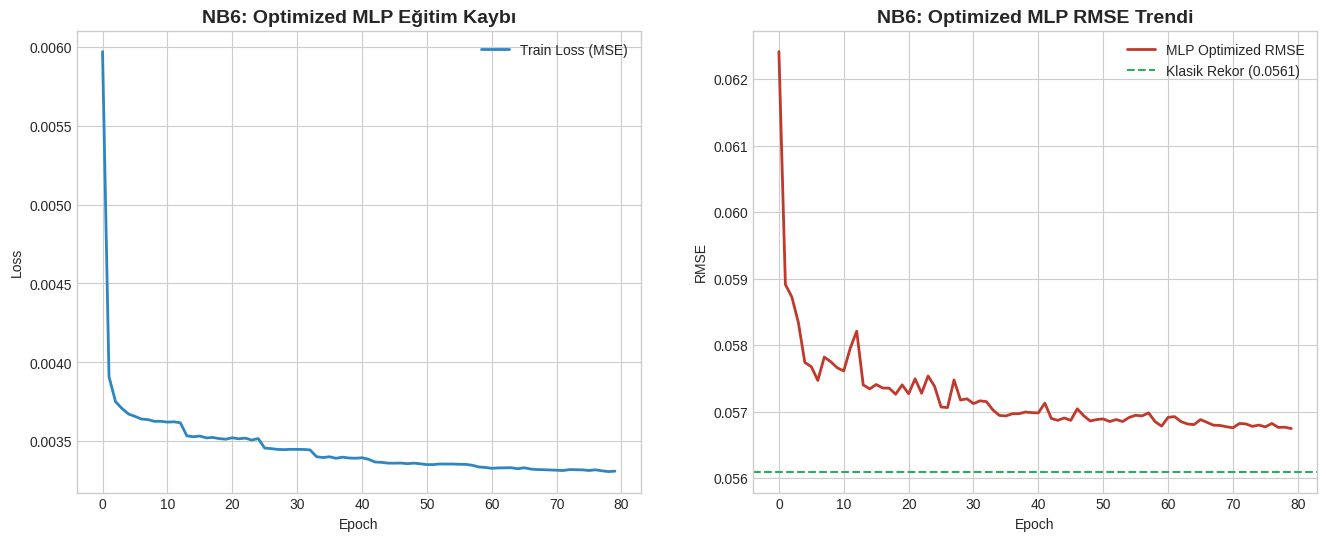

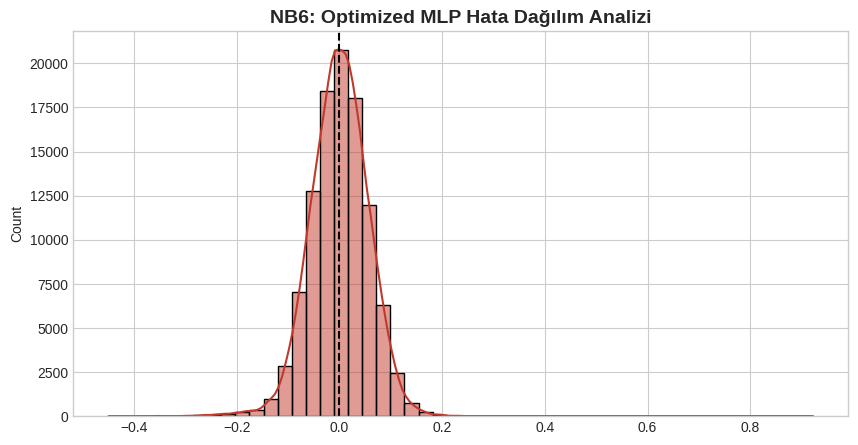

In [ ]:
# --- FIGURES KLASÖRÜ HAZIRLIĞI ---
figures_path = os.path.join(base_path, 'figures')
os.makedirs(figures_path, exist_ok=True)

# 1. Eğitim ve Performans Grafikleri
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(train_losses, color='#2E86C1', linewidth=2, label='Train Loss (MSE)')
ax1.set_title('NB6: Optimized MLP Eğitim Kaybı', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend()

ax2.plot(val_rmses, color='#C0392B', linewidth=2, label='MLP Optimized RMSE')
ax2.axhline(y=0.0561, color='#27AE60', linestyle='--', label='Klasik Rekor (0.0561)')
ax2.set_title('NB6: Optimized MLP RMSE Trendi', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch'); ax2.set_ylabel('RMSE'); ax2.legend()

# Kaydetme
plt.savefig(os.path.join(figures_path, '06_optimized_mlp_performance.png'), dpi=300, bbox_inches='tight')
plt.show()

# 2. Hata Dağılımı (Residuals)
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, color='#C0392B', bins=50)
plt.axvline(x=0, color='black', linestyle='--')
plt.title('NB6: Optimized MLP Hata Dağılım Analizi', fontsize=14, fontweight='bold')
plt.savefig(os.path.join(figures_path, '06_optimized_mlp_residuals.png'), dpi=300, bbox_inches='tight')
plt.show()

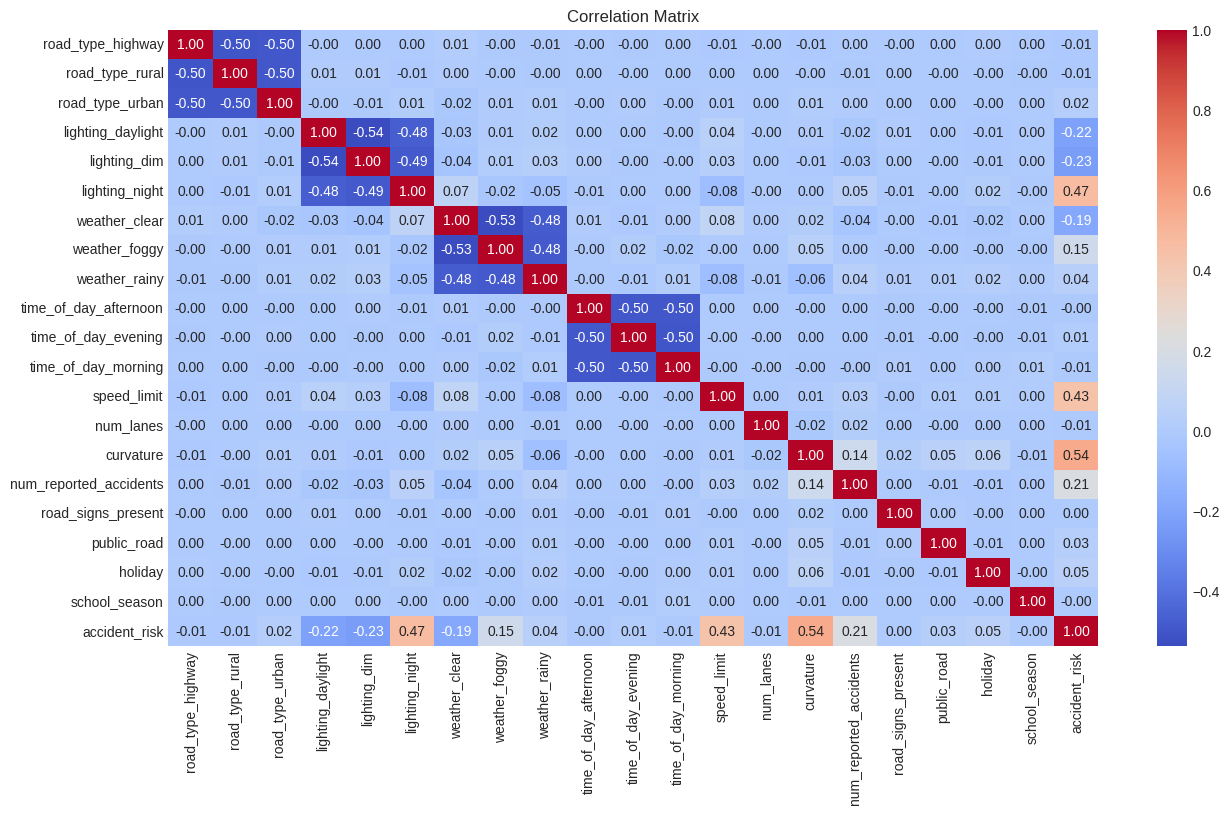


Accident Risk ile Korelasyonlar:
accident_risk             1.000000
curvature                 0.543919
lighting_night            0.465915
speed_limit               0.431436
num_reported_accidents    0.213730
weather_foggy             0.151052
holiday                   0.050465
weather_rainy             0.035296
public_road               0.031386
road_type_urban           0.021864
time_of_day_evening       0.009865
road_signs_present        0.000689
school_season            -0.001145
time_of_day_afternoon    -0.003364
num_lanes                -0.005293
time_of_day_morning      -0.006506
road_type_rural          -0.010077
road_type_highway        -0.011731
weather_clear            -0.185597
lighting_daylight        -0.215038
lighting_dim             -0.233517
Name: accident_risk, dtype: float64
Figür 'correlation_matrix.png' adıyla başarıyla kaydedildi.


<Figure size 640x480 with 0 Axes>

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# 1. Notebook 1'de dosyaları kaydettiğin yolu buraya yaz
# Eğer klasör yapın farklıysa tırnak içini ona göre güncelle
path = "/content/drive/MyDrive/YAP470_Proje/processed/X_train_processed.csv"
target_path = "/content/drive/MyDrive/YAP470_Proje/processed/y_train.csv"

# 2. Dosyaların varlığını kontrol edip yükleyelim
if os.path.exists(path):
    X = pd.read_csv(path)
    y = pd.read_csv(target_path)

    # Analiz için birleştirelim
    X['accident_risk'] = y.values

    # 3. KORELASYON GRAFİĞİ (Isı Haritası)
    plt.figure(figsize=(15, 8))
    corr = X.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix")
    plt.show()

    # 4. RAPOR İÇİN RAKAMLAR
    print("\nAccident Risk ile Korelasyonlar:")
    print(corr['accident_risk'].sort_values(ascending=False))
    # Grafiği çizdirdikten hemen sonra (plt.show() komutundan önce veya sonra)
else:
    print("HATA: Dosya bulunamadı! Lütfen Drive'da 'processed' klasörünün içindeki dosya adını kontrol et.")